In [83]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD


In [84]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords', download_dir='/usr/local/share/nltk_data')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Matheus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [85]:
df = pd.read_csv("twitter_training.csv")
df.columns = ['ID', 'Category', 'Sentiment', 'Tweet']
print(df.columns)

Index(['ID', 'Category', 'Sentiment', 'Tweet'], dtype='object')


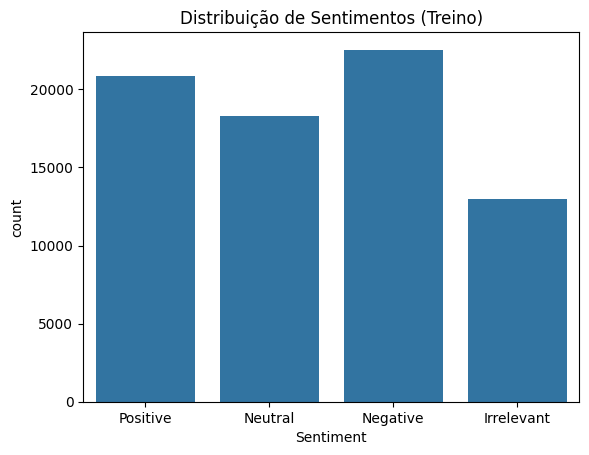

In [86]:
sns.countplot(data=df, x='Sentiment')
plt.title("Distribuição de Sentimentos (Treino)")
plt.show()

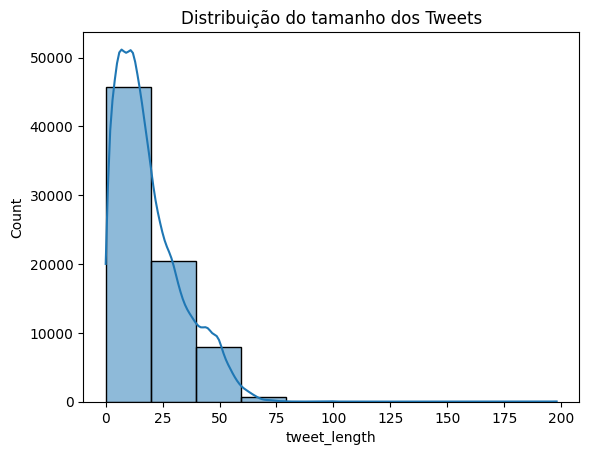

In [87]:
df['tweet_length'] = df['Tweet'].astype(str).apply(lambda x: len(x.split()))
sns.histplot(df['tweet_length'], bins=10, kde=True)
plt.title("Distribuição do tamanho dos Tweets")
plt.show()


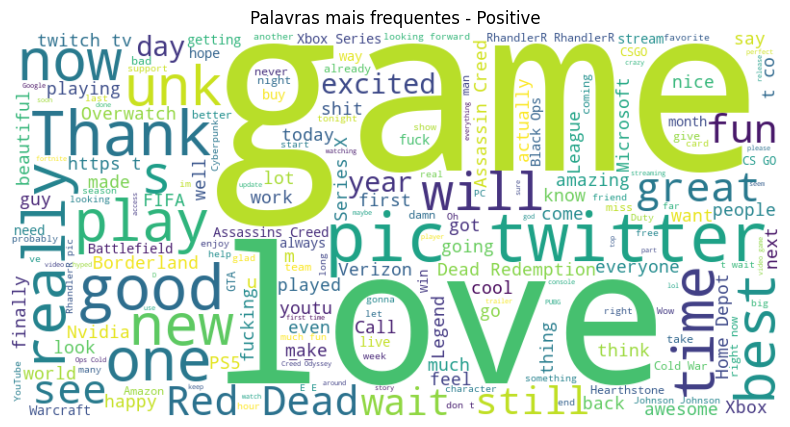

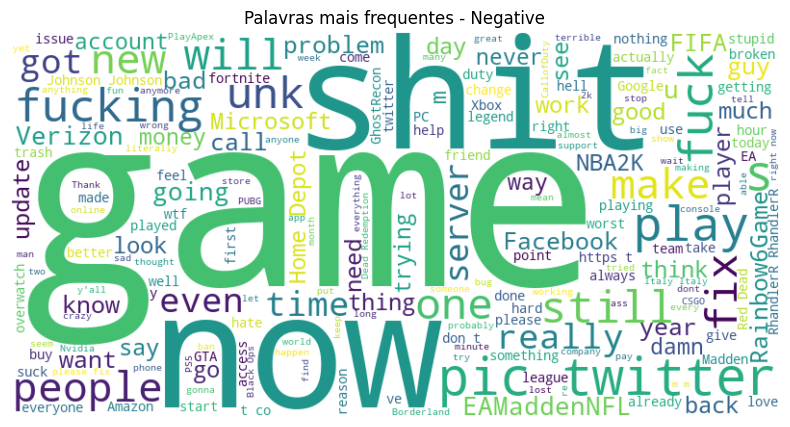

In [88]:
from collections import Counter
from wordcloud import WordCloud

def plot_wordcloud(sentiment):
    text = ' '.join(df[df['Sentiment'] == sentiment]['Tweet'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Palavras mais frequentes - {sentiment}")
    plt.show()

plot_wordcloud('Positive')
plot_wordcloud('Negative')

In [89]:
print(df.isnull().sum())
print(f"Duplicados: {df.duplicated().sum()}")


ID                0
Category          0
Sentiment         0
Tweet           686
tweet_length      0
dtype: int64
Duplicados: 2700


In [90]:
# Remover duplicatas e valores ausentes
df.dropna(subset=['Tweet'], inplace=True)
df = df.drop_duplicates(subset=['Tweet'])

#df = df[df['Tweet'].str.split().str.len() > 3]
#df = df[df['Sentiment'] != 'neutral']
print(df.isnull().sum())
print(f"Duplicados: {df.duplicated().sum()}")

ID              0
Category        0
Sentiment       0
Tweet           0
tweet_length    0
dtype: int64
Duplicados: 0


In [91]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)  # Tokenização
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

In [93]:
# Aplicar pré-processamento
df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_text).astype(str)

In [94]:
# Codificação e divisão
y = LabelEncoder().fit_transform(df['Sentiment'].astype('str'))
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Tweet'], y, test_size=0.2, random_state=42)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

print(df)

         ID     Category Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74676  9200       Nvidia  Positive   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   

                                                   Tweet  tweet_length  \
0      I am coming to the borders and I will kill you...            12   
1      im getting on borderlands and i will kill you ...            10   
2      im coming on borderlands and i will murder you...            10   
3      im getting on borderlands 2 and i will murder ...            12   
4      im getting into borderlands and i can murder y...            10   
...                                                  ...           ...   
74676  Just realized that

In [99]:
# Modelos e hiperparâmetros
vectorizers = {
    'bow': CountVectorizer(max_features=2000, ngram_range=(1, 2)), #alterei manualmmente (Notei que quanto mais features, menor a %.)
    'tfidf': TfidfVectorizer(max_features=2000, ngram_range=(1, 2)) 
}

models = {
    'logistic_regression': LogisticRegression(penalty='l2', max_iter=1000),
    'naive_bayes': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'mlp': MLPClassifier(max_iter=150) #alterei manualmmente (oscilou em 0.45 a 0.5)
}

grid_params = {
    'logistic_regression': {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
    'knn': {'n_neighbors': [2, 4, 8, 12]},
    'mlp': {'hidden_layer_sizes': [
            (2,), (4,), (8,), (16,), (32,),  # 1 camada
            (2, 2), (4, 4), (8, 8), (16, 16), (32, 32),  # 2 camadas
            (2, 2, 2), (4, 4, 4), (8, 8, 8), (16, 16, 16), (32, 32, 32)  # 3 camadas
        ]
    }
}


In [100]:
# Execução dos modelos
results = []

for vec_name, vectorizer in vectorizers.items():
    # Vetorização correta
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Aplicar SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

    for model_name, model in models.items():
        print(f'Treinando {model_name} com {vec_name}...')

        if model_name in ['naive_bayes', 'knn', 'mlp']:
            X_train_input = X_train_resampled.toarray()
            X_test_input = X_test_vec.toarray()
            X_train_input = StandardScaler().fit_transform(X_train_input)
            X_test_input = StandardScaler().fit_transform(X_test_input)
        else:
            X_train_input = X_train_resampled
            X_test_input = X_test_vec

        # TruncatedSVD ao invés de PCA
        steps = []
        if X_train_input.shape[1] > 50:
            steps.append(('svd', TruncatedSVD(n_components=50)))
        steps.append(('clf', model))
        pipeline = Pipeline(steps)

        if model_name in grid_params:
            adjusted_params = {f'clf__{key}': value for key, value in grid_params[model_name].items()}
            grid = RandomizedSearchCV(pipeline, adjusted_params, scoring='accuracy', cv=3, n_jobs=-1)
            grid.fit(X_train_input, y_train_resampled)
            best_model = grid.best_estimator_
        else:
            best_model = pipeline.fit(X_train_input, y_train_resampled)

        y_pred = best_model.predict(X_test_input)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        results.append((vec_name, model_name, acc, prec, rec))

# Exibir resultados
for res in results:
    print(f'Representação: {res[0]}, Modelo: {res[1]}, Acurácia: {res[2]:.4f}, Precision: {res[3]:.4f}, Recall: {res[4]:.4f}')

c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Treinando logistic_regression com bow...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Treinando naive_bayes com bow...
Treinando knn com bow...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Treinando mlp com bow...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Treinando logistic_regression com tfidf...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Treinando naive_bayes com tfidf...
Treinando knn com tfidf...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Treinando mlp com tfidf...


c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Representação: bow, Modelo: logistic_regression, Acurácia: 0.4351, Precision: 0.4723, Recall: 0.4351
Representação: bow, Modelo: naive_bayes, Acurácia: 0.2880, Precision: 0.4056, Recall: 0.2880
Representação: bow, Modelo: knn, Acurácia: 0.7808, Precision: 0.7942, Recall: 0.7808
Representação: bow, Modelo: mlp, Acurácia: 0.5413, Precision: 0.5627, Recall: 0.5413
Representação: tfidf, Modelo: logistic_regression, Acurácia: 0.4670, Precision: 0.4861, Recall: 0.4670
Representação: tfidf, Modelo: naive_bayes, Acurácia: 0.3576, Precision: 0.4363, Recall: 0.3576
Representação: tfidf, Modelo: knn, Acurácia: 0.7728, Precision: 0.7979, Recall: 0.7728
Representação: tfidf, Modelo: mlp, Acurácia: 0.5339, Precision: 0.5572, Recall: 0.5339
